In [72]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import cartopy.crs as ccrs
%matplotlib inline

## Optional: add extra workers
* not really necessary here, I don't think

In [2]:
#for use on Casper
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=18,
                     processes=18, memory="190GB",
                     project='P93300041',
                     walltime='2:00:00')
cluster.scale(18)
client = Client(cluster)

In [2]:
#for use on cheyenne
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(cores=36,
                     processes=36, memory="109GB",
                     project='P93300041',
                     queue='regular',
                     resource_spec='select=1:ncpus=36:mem=109G',
                     walltime='02:00:00')
cluster.scale(36)
client = Client(cluster)

/glade/u/apps/ch/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [5]:
client

Client Scheduler: tcp://10.148.10.17:37225 Dashboard: http://10.148.10.17:39497/status,Cluster Workers: 36 Cores: 36 Memory: 109.08 GB


## Read in the data

In [173]:
# define some info for the ensemble 
ens = range(33)
thedir = '/glade/scratch/djk2120/mini_ens/output/'
paths = [thedir+'miniens_oaat'+str(ee).zfill(4)+'_h1.nc' for ee in ens]
pftnames = ['BG','NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES',
            'BDMS','BDBS','C3ArG','C3G','C4G','C3C']
pftindex={}
for i,v in zip(range(16),pftnames):
    pftindex[v]=i

In [174]:
# grab only FPSN and TLAI from all the ensemble members
#    note that this is PFT level output
ens_vars = ['FPSN','TLAI']
def preprocess(ds):
    return ds[ens_vars]
ds = xr.open_mfdataset(paths,combine='nested',concat_dim='ens',decode_cf=False,
                       preprocess=preprocess,parallel='True')
ds['ens']=ens

In [175]:
# grab just one copy of the various extra variables
extra_vars = xr.open_dataset(paths[0],decode_cf=False)
for v in extra_vars.data_vars:
    if v not in ens_vars:
        ds[v]=extra_vars[v]

In [97]:
# redefine the time dimension
#    xarray not very good at interpreting CESM time fields
time_vector = cftime.num2date(ds['time'].values-16,units=ds['time'].attrs['units'],
                calendar=ds['time'].attrs['calendar'])
ds['time']=xr.DataArray(time_vector,attrs=ds['time'].attrs)

## Some analysis examples


### Where are the needleleaf temperate tree gridcells?

In [102]:
ixpft = ds['pfts1d_itype_veg']==pftindex['NEMT']
lats = ds['pfts1d_lat'][ixpft]
lons = ds['pfts1d_lon'][ixpft]
lons[lons>180]=lons[lons>180]-360  #needed to match cartopy

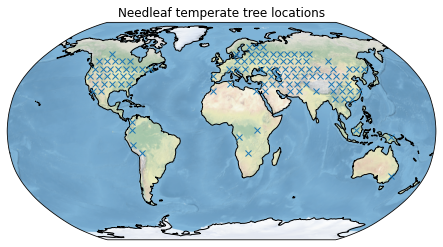

In [108]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.stock_img()
ax.coastlines()
ax.plot(lons, lats, 'x', transform=ccrs.PlateCarree())
plt.title('Needleaf temperate tree locations');

### MAX LAI for broadleaf evergreen tropical trees
- preserving gridcell information

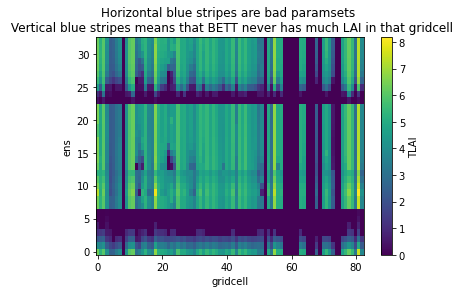

In [171]:
ixpft = ds['pfts1d_itype_veg']==pftindex['BETT']
ds['TLAI'].isel(pft=ixpft).max(axis=1).plot() #take the max along the time-axis
plt.xlabel('gridcell')
plt.title('Horizontal blue stripes are bad paramsets \n Vertical blue stripes means that BETT never has much LAI in that gridcell');

### MAX LAI across PFTs
- take the max and then average across gridcells

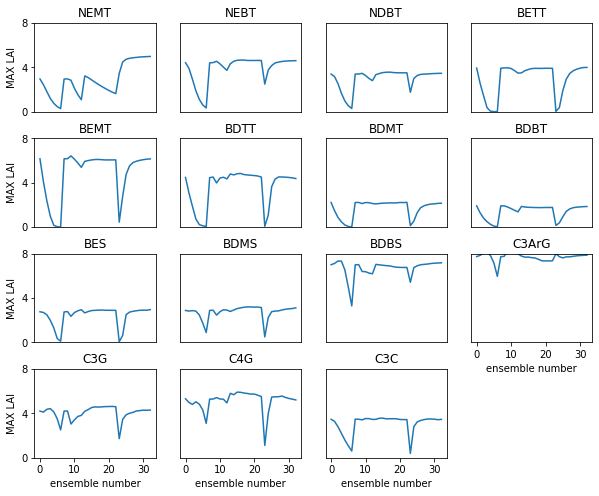

In [170]:
plt.figure(figsize=[10,8])
for i in 1+np.arange(15):  #loop through the 15 pfts

    #analysis bits
    ixpft = ds['pfts1d_itype_veg']==i
    maxlai = ds['TLAI'].isel(pft=ixpft).max(axis=1).mean(axis=1)
    
    #plotting
    plt.subplot(4,4,i)
    plt.plot(maxlai)
    if (i==1)|(i==5)|(i==9)|(i==13):
        plt.ylabel('MAX LAI')
        plt.yticks([0,4,8])
    else:
        plt.yticks([])
    if i>11:
        plt.xlabel('ensemble number')
    else:
        plt.xticks([])
    plt.title(pftnames[i])
    plt.ylim([0,8])
    
plt.subplots_adjust(hspace=0.3)

### AVG FPSN across PFTs
- averaged across gridcells

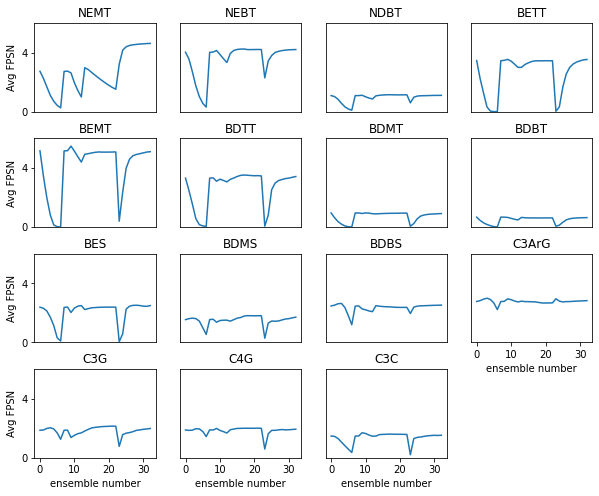

In [169]:
plt.figure(figsize=[10,8])
for i in 1+np.arange(15):  #loop through the 15 pfts

    #analysis bits
    ixpft   = ds['pfts1d_itype_veg']==i
    avgfpsn = ds['TLAI'].isel(pft=ixpft).groupby('ens').mean(dim=xr.ALL_DIMS)
    
    #plotting
    plt.subplot(4,4,i)
    plt.plot(ds['ens'],avgfpsn)
    if (i==1)|(i==5)|(i==9)|(i==13):
        plt.ylabel('Avg FPSN')
        plt.yticks([0,4,8])
    else:
        plt.yticks([])
    if i>11:
        plt.xlabel('ensemble number')
    else:
        plt.xticks([])
    plt.title(pftnames[i])
    plt.ylim([0,6])
    
plt.subplots_adjust(hspace=0.3)

## Some extra code

### If you want to look at gridcell output
* (contains more variables)
* note that this is likewise has collapsed spatial dimension

In [188]:
gridpaths = paths = [thedir+'miniens_oaat'+str(ee).zfill(4)+'_h0.nc' for ee in ens]
ds_grid = xr.open_mfdataset(gridpaths,combine='nested',concat_dim='ens',
                       decode_cf=False,parallel='True')
ds_grid['ens']=ens

In [189]:
time_vector = cftime.num2date(ds_grid['time'].values-16,
                              units=ds_grid['time'].attrs['units'],
                              calendar=ds_grid['time'].attrs['calendar'])
ds_grid['time']=xr.DataArray(time_vector,attrs=ds_grid['time'].attrs)

### If you want the param values
* safe to average across segment/variants for kmax and rpb
* might also consider averaging across PFTS 1-15 if you want a single value
* varying params provided in paramlist
    * ['medlynslope', 'kmax', 'hksat_adjustfactor', 'krmax', 'rootprof_beta']

In [222]:
pdir = '/glade/scratch/djk2120/mini_ens/paramfiles/'
parampaths = sorted(glob.glob(pdir+'*.nc'))
params = xr.open_mfdataset(parampaths,combine='nested',concat_dim='ens',parallel='True')
params['ens']=ens
params['kmax']=params['kmax'].mean(axis=1)
params['rootprof_beta']=params['rootprof_beta'].mean(axis=1)
paramlist = ['medlynslope', 'kmax', 'hksat_adjustfactor', 'krmax', 'rootprof_beta']

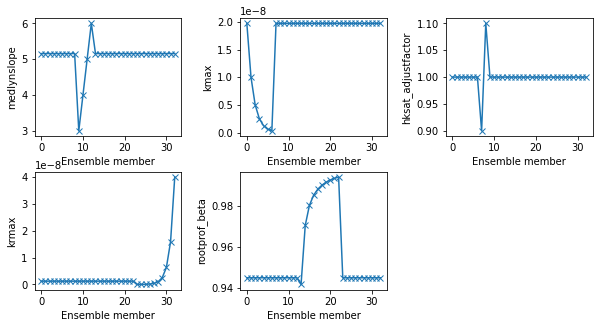

In [240]:
i=0
plt.figure(figsize=[10,5])
for p in paramlist:
    if len(params[p].values.shape)>1:
        param_single_value = params[p].mean(axis=1)
    else:
        param_single_value = params[p]
    i = i+1
    plt.subplot(2,3,i)
    plt.plot(param_single_value,'-x')
    plt.xlabel('Ensemble member')
    plt.ylabel(p);
plt.subplots_adjust(hspace=0.3,wspace=0.4)